# Machine Learning - Primera parte


## Datos

- *Alumno:* Ricardo Alexis Lopez Cadena
- *Para la materia de:* Clasificación de Datos
- *Universidad de Guadalajara - Centro Universitario de Ciencias Exactas e Ingenierías*
- *Sección D03*

## Objetivo
En la colaboración de un proyecto sobre inventarios de bienes, se desea agregar un módulo de *Machine Learning* para ayudar en base al aprendizaje automático a sugerir clasificadores más pertinentes dentro del catálogo; con tus algoritmos propuestos necesitas encontrar los errores en las clasificaciones y las inconsistencias, para que de esta manera se pueda ajustar el modelo para que sea incorporado a la operación diaria de una aplicación. Ese es el objetivo.

En otras palabras, **encontrar qué items se encuentran en clasificaciones erroneas y corregirlo, además de realizar clasificaciones y subclasificaciones de los items.**

## Problemática
*Es de notar, que lo que se tiene en este archivo son valores únicos por tupla.*

Dentro de este conjunto de datos hay registros que, con toda probabilidad, estén en un lugar equivocado, la intención es buscar los modelos adecuados de algoritmia, para identíficar cuales tuplas con mucha probabilidad están equivocadas.

## Codificación - Proceso de Clasificación

### Estrategía
- **DRY (Don't Repeat Yourself)**
    - Realizar funciones puede ser más complejo debido a que se tiene que pensar en la reusabilidad pero es bastante satisfactorio evitar tareas repetitivas, **el principio DRY permite que el código sea más legible, sea menos código reduciendo así su complejidad y promoviendo la mantenibilidad**

### Módulos requeridos

In [42]:
import pandas as pd # DataFraming
import numpy as np
from matplotlib import pyplot as plt
# to enable the inline plotting within frontends like Jupyter Notebook:
%matplotlib inline

#import re as regex  # Regular expressions

### Carga de Dataset 
Debido a que el archivo de excel carece de nombres de columnas, se han nombrado las columnas por conveniencia:
- **type**, primer columna
- **class**, segunda columna
- **description**, tercera columna


In [43]:
def loadDataset(fileName):
    return pd.read_excel(fileName)

In [44]:
dataFrame = loadDataset('Actividad.xlsx')
dataFrame.head()

,type,class,description
0,Mobiliario,Mobiliario,SILLON EJECUTIVO RESPALDO MEDIO COLOR NEGRO. N...
1,Mobiliario,Mobiliario,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).
2,Equipo,Equipo,"MONITOR DE COLOR HP DE 15"", N.D. 017/2002 ALTA..."
3,Mobiliario,Mobiliario,"CESTO DE BASURA ALUMINIO N.D. 007/2005, ALTA 3..."
4,Transporte,Transporte,"AUTOMOVIL FORD ESCORT 1998, PLACAS: HZG1129, N..."


### Contabilidad de tipos

Es necesario comprender cuantos tipos se encuentran en el Dataset.

Nota: en una primera versión de `findTypes()` se encontraba en la lista un item `nan`, por lo que decido deshacerme de este directamente en el ciclo.

In [45]:
def findTypes(typesColumn):
    types = list()

    for type in typesColumn:
        if type not in types and str(type) != 'nan':
            types.append(type)
    
    return types

In [46]:
typesFound = findTypes(dataFrame['type'])

print(f'Los tipos encontrados son {len(typesFound)}: \n')

print('\n'.join(map(str, typesFound)))

Los tipos encontrados son 6: 

Mobiliario
Equipo
Transporte
Bienes CulturalesArtísticos y Científicos
Libro
Propiedad Intelectual


### Limpieza

#### Filas vacías
Limpiando aquellas filas que están vacías o bien les falta al menos un valor.

In [47]:
def cleanDatasetRows(dataFrame):
    def oneValueMissing(dataFrame):
        return dataFrame.dropna()
    def allValuesMissing(dataFrame):
        return dataFrame.dropna(how='all')
    
    return allValuesMissing(oneValueMissing(dataFrame))

In [48]:
"""
Pandas DataFrames interpret empty strings as 'not null' so
    set empty rows to numpy NaN values:
"""
dataFrame["description"].replace('', np.nan, inplace=True)

dataFrame = cleanDatasetRows(dataFrame)
print(f'La limpieza de filas se ha realizado y ahora son: {len(dataFrame)} filas')

La limpieza de filas se ha realizado y ahora son: 9993 filas


#### Filtro de palabras para eliminar el ruido en el nombre del item

In [49]:
# Must be in lowercase:
wordsFilter = set(['de', 'con', 'y', '', 'sin', 'que', 'o', 'a', 'la', 'al',
                   'un', 'una', 'los', 'las', 'por', 'en', 'no.', 'n.d', 'para',
                   's/m', 's/m,', 's/n', 's/n.', 'el', 'del', 'xla',
                   '"a', 'es', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                   '10', '-', '#', 'color', 'muy', 'ni', 'no', 'caracteristicas:',
                   'características:', 'n.d.', 's/n:',''])


#### Columna de descripcion

In [50]:
def cleanSentenceWords(sentence, wordsfilter):
    def cleanWordRecursive(sentence, word):
        if word in sentence:
            sentence.remove(word)
            cleanWordRecursive(sentence, word)
        else:
            return

    sentenceTokens = sentence.casefold().split()
    
    for word in wordsFilter:
        if word in sentenceTokens:
            cleanWordRecursive(sentenceTokens,word)
            
    return ' '.join(sentenceTokens)

# maybe:
#def cleanSentenceByRegEx(sentence, regEx):

In [51]:
def cleanFirstCharacterSpace(word):
    try:
        if word[0] == ' ':
            word = word[1:]
    except Exception as error:
        print(f'a row has escaped empty rows cleansing, leading to: {error}')
    return word

In [52]:
def cleanSentenceCharacters(sentence):
    characters = set(['"', '\'', ',', ', ', ';','#', ':', 'P/'])
    for char in characters:
        sentence = sentence.replace(char,'')
    return sentence

In [53]:
def cleanDescriptionColumn(row):
    row = cleanSentenceWords(row, wordsFilter).upper()
    row = cleanFirstCharacterSpace(row)
    row = cleanSentenceCharacters(row)
    return row 

In [54]:
dataFrameCopy = dataFrame.copy()
dataFrame["description"] = dataFrame["description"].astype(str).apply(cleanDescriptionColumn)

a row has escaped empty rows cleansing, leading to: string index out of range


#### Mostrando diferencias - Antes y después de la limpieza

In [55]:
dataFrameCopy.head()

,type,class,description
0,Mobiliario,Mobiliario,SILLON EJECUTIVO RESPALDO MEDIO COLOR NEGRO. N...
1,Mobiliario,Mobiliario,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).
2,Equipo,Equipo,"MONITOR DE COLOR HP DE 15"", N.D. 017/2002 ALTA..."
3,Mobiliario,Mobiliario,"CESTO DE BASURA ALUMINIO N.D. 007/2005, ALTA 3..."
4,Transporte,Transporte,"AUTOMOVIL FORD ESCORT 1998, PLACAS: HZG1129, N..."


In [56]:
dataFrame.head()

,type,class,description
0,Mobiliario,Mobiliario,SILLON EJECUTIVO RESPALDO MEDIO NEGRO. ND 13/2...
1,Mobiliario,Mobiliario,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).
2,Equipo,Equipo,MONITOR HP 15017/2002 ALTA 07 OCTUBRE 2002
3,Mobiliario,Mobiliario,CESTO BASURA ALUMINIO 007/2005ALTA 31 AGOSTO 2005
4,Transporte,Transporte,AUTOMOVIL FORD ESCORT 1998PLACAS HZG1129SERIE ...


### Clasificación de datos

#### Creando una nueva columna 'item'
Esta servirá para guardar el nombre del item, usando una función que tome las primeras dos palabras de la descripción.

In [57]:
def getItemName(sentence):
    sentenceTokens = sentence.split()
    return ' '.join(sentenceTokens[:2])

In [58]:
dataFrameCopy = dataFrame.copy()

In [59]:
dataFrameCopy["item"] = dataFrameCopy["description"].astype(str).apply(getItemName)
dataFrameCopy.head()

,type,class,description,item
0,Mobiliario,Mobiliario,SILLON EJECUTIVO RESPALDO MEDIO NEGRO. ND 13/2...,SILLON EJECUTIVO
1,Mobiliario,Mobiliario,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).,PINTARRON 60X90
2,Equipo,Equipo,MONITOR HP 15017/2002 ALTA 07 OCTUBRE 2002,MONITOR HP
3,Mobiliario,Mobiliario,CESTO BASURA ALUMINIO 007/2005ALTA 31 AGOSTO 2005,CESTO BASURA
4,Transporte,Transporte,AUTOMOVIL FORD ESCORT 1998PLACAS HZG1129SERIE ...,AUTOMOVIL FORD


#### Exportando a CSV para realizar observaciones
He exportado el proceso realizado hasta ahora para una observación en la columna 'item' y pensar sobre un criterio para clasificación

In [60]:
#dataFrameCopy.to_csv('act_processed.csv')

#### Creación de filtros para clasificación
Este objeto es un objeto `Dictionary` que contiene otro `Dictionary` por cada subClasificación, si se quisiera realizar una sub-subclasificación se usaría nuevamente otro `Dictionary` por cada sub-subclasificación dentro de la clasificación, **la complejidad de los algoritmos que tengan la capacidad de recorrer este objeto oscilaría entre n³ o n⁴**

In [61]:
classificationFilters = {
    'Transporte' : {
        'automovil' : ['AUTOMOVIL','PASAJEROS','SEDAN','CAMIONETA','LANCHA','PICKUP','PICK','VEHICULAR''AUTOBUS',
                    'CAMION','MOTO','MOTOCICLETA','VEHICULO','UNIDAD','HONDA','TSURU','CRV','FRONTIER'],
    },
    'Mobiliario' : {
        'oficina' : ['TARJETA','TABLERO','MODULO','NOTEBOOK','NETBOOK','ANALIZADOR','COMPRESOR','ARCHIVERO',
                     'LAMPARA','MAMPARA','ANAQUEL','LIBRERO','PERCHERO','CALENTADOR','SALA','SECRETARIAL',
                    'BASE','SILLA','MUEBLE','FOTOCOPIADORA'],
        'cocina' : ['HORNO','ESTUFA','REFRIGERADOR','MICROONDAS','CAFETERRA','COCINA','ALACENA','CONGELADOR',
                   'PARRILLA'],
        'educacion' : ['PIZZARON','PINTARRON'],
    },
    'Equipo' : {
        'electronico' : ['MONITOR','REGULADOR','TELEFONO','COMPUTADORA','CPU','MOUSE','RATON','TECLADO',
                         'BREAK','NOBREAK','AUDIFONO','MICROFONO','GRABADORA','SCANER','PROYECTOR','LAPTOP',
                        'PANTALLA','LASSER','LASER','RW','MEMORIA','KINGSTON','PENTIUM','USB','PROCESADOR',
                        'CONSOLA','TOSHIBA','SONY','CAMARA','SWITCH','DRIVE','SERVIDOR','RED','TP','ROUTER',
                         'ROUTERS','CONMUTADOR','MODEM','FLOPPY','ELECTRONICO','DIGITAL','TRAKER','TRACKER'
                        'DISCO DURO','IMPRESORA','REGISTRADORA','VIDEO','VIDEOCASETERA','DVD'],
        'seguridad' : ['BOTIQUIN','EXTINTOR','EXTINGUIDOR'],
        'mantenimiento' : ['PODADORA','PULIDORA','HERRAMIENTAS'],
        'pintura' : ['PINTURA','ACRILICO','MURAL']
    },
    'Bienes CulturalesArtísticos y Científicos' : {
        'obra artística' : ['OBRA','LITOGRAFIA'],
        'obra cientifica' : ['DOCUMENTO', 'HISTORICO'],
    },
    'Libro' : {
      'libro' : ['LIBRO','CUENTO','REVISTA','VAQUERO','LUNA DE PLUTON']
    },
    'Propiedad Intelectual' : {
        'licencia' : ['LICENCIA','ENCUESTA']
    }
}

#### Clasificando y reescribiendo columna 'class'
- La función `matchTypes()` actualmente retorna la clase y la subclase para la clasificación. Se espera que después exista una subclase de la subclase **para clasificación de tres niveles**.
- La función `isMatch()` retorna verdadero si dentro del nombre del item se encuentra una palabra clave que entre en una clasificación.
- Existen dos rutinas de clasifiación: `clasificationOnClass` y `clasificationOnType`, una afecta a la columna **clase** y la otra afecta a la columna **type**.
- Existen dos algoritmos de *'clasifación'* realizados para la columna **class**: 
    - **clasificación normal:** si no encuentra clasificación adecuada, deja la clasificación que tiene.
    - **clasificación 'bruta':** si no encuentra clasificación adecuada, descarta la instancia para ser eliminada posteriormente.

In [62]:
def isMatch(values, itemName):
            for word in itemName:
                if word in values:
                    return True
            return False
        
def matchTypes(parentDictionary, itemName):
    for parentType, childDictionary in parentDictionary.items():
        for childType, valuesList in childDictionary.items():
            if isMatch(valuesList, itemName.split()):
                return parentType, childType
    return False, False

In [63]:
## --- NORMAL CLASIFICATION
def classificationOnClass(parentDictionary, row):
    _, itemClass = matchTypes(parentDictionary, row["item"])    
    if itemClass is not False:
        return itemClass
    return row["class"]
    #return itemClass if not False else row["class"]

## --- CLASIFICATION THAT DISCARDS NOT CLASSIFIED VALUES

#def bruteClassificationOnClass(parentDictionary, row):            
 #   _, itemClass = matchTypes(parentDictionary, row["item"])    
  #  return itemClass if not False else np.nan
   # # after this, can call cleanDatasetRows() again


In [64]:
dataFrameCopy['class'] = dataFrameCopy.astype(str).apply(
    lambda row: classificationOnClass(classificationFilters, row), axis=1,
    #lambda row: bruteClassificationOnClass(classificationFilters, row), axis=1
)

#### Clasificando y reescribiendo columna 'type'
Se busca asegurar que la columna **class** se encuentre correctamente en el conjunto padre de la columna **type**  por lo que `classificationOnType()`se asegura que esta premisa se cumpla.

Referencia: ver objeto `Dictionary` -> `classificationFilters`

In [65]:
def classificationOnType(parentDictionary,row):
    itemType, _ = matchTypes(parentDictionary, row["item"])    
    if itemType is not False:
        return itemType
    return row["type"]
    #return itemType if not False else row["type"]

In [66]:
dataFrameCopy['type'] = dataFrameCopy.astype(str).apply(
    lambda row: classificationOnType(classificationFilters, row), axis=1,
    #lambda row: bruteClassificationOnClass(classificationFilters, row), axis=1
)

In [ ]:
#dataFrameCopy["class"] = dataFrameCopy.astype(str).apply(lambda x: x["class"].casefold(),axis=1)

#### Limpieza opcional
Si se usó `bruteClassificationOnClass()` se hace una limpieza: eliminando filas que no pudieron ser clasificadas.

- Se puede exportar el dataset para una visualización antes y después de la limpieza *descomentando* las lineas de código correspondientes en el siguiente bloque:

In [67]:
# Before brute cleansing
dataFrameCopy.to_csv('dataset_processed.csv')

# After brute cleansing
#dataFrameCopy = cleanDatasetRows(dataFrameCopy)
#dataFrameCopy.to_csv('dataset_processed_used_nan.csv') 

## Codificación - Vista de clasificaciones

### Carga dataset procesado
Optando por el camino de no usar la *clasificación 'bruta'* se carga el dataset que no ha sido afectado por esta.

In [135]:
groupDataSet = pd.read_csv('dataset_processed.csv')

### Se convierten los atributos de la columna 'class' a solo minuscula
No necesitamos que los atributos tengan letra capitalizada

In [136]:
groupDataSet.drop('Unnamed: 0', axis=1, inplace=True)

In [137]:
groupDataSet["class"] = groupDataSet.astype(str).apply(lambda x: x["class"].casefold(),axis=1)

groupDataSet.head()

,type,class,description,item
0,Mobiliario,mobiliario,SILLON EJECUTIVO RESPALDO MEDIO NEGRO. ND 13/2...,SILLON EJECUTIVO
1,Mobiliario,educacion,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).,PINTARRON 60X90
2,Equipo,electronico,MONITOR HP 15017/2002 ALTA 07 OCTUBRE 2002,MONITOR HP
3,Mobiliario,mobiliario,CESTO BASURA ALUMINIO 007/2005ALTA 31 AGOSTO 2005,CESTO BASURA
4,Transporte,automovil,AUTOMOVIL FORD ESCORT 1998PLACAS HZG1129SERIE ...,AUTOMOVIL FORD


### Codificación - Conteo
Por cada clasificación encontrada se cuentan las instancias que entran en cada una.

In [155]:
print('Tipos:')
print('\n'.join(map(str, typesFound)))
print('\n')
print('Cantidad:')
print('\n'.join(map(str, typesCount)))

Tipos:
Mobiliario
Equipo
Transporte
Bienes CulturalesArtísticos y Científicos
Libro
Propiedad Intelectual


Cantidad:
2724
5625
83
18
1534
9


In [139]:
typesCount = list()
for a_type in typesFound:
    count = groupDataSet[ groupDataSet["type"] == a_type ].count()
    typesCount.append(count.type)

## Codificación - Graficación
Obtención de subdatasets no automatizada para mostrar cada tabla

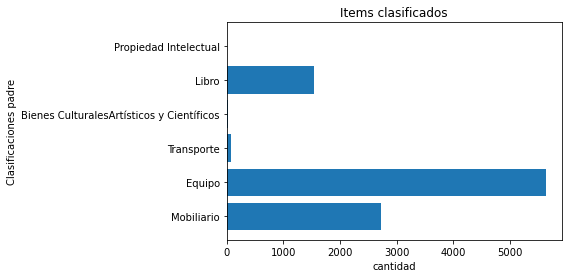

In [151]:
fig, ax = plt.subplots()

ax.barh(typesFound,typesCount)
plt.title('Items clasificados')
plt.ylabel('Clasificaciones padre')
plt.xlabel('cantidad')
plt.show()

## Vista generica de la clasificación terminada.
Mostrando el primer item de cada subclasificación

In [160]:
showGroupDataSet = groupDataSet.copy()
showGroupDataSet.groupby(['type','class']).first()

description  \
type                                      class                                                                      
Bienes CulturalesArtísticos y Científicos obra artística                                   CUADRO LITOGRAFIA SIBYL   
                                          obra cientifica        DOCUMENTO HISTORICO. GENERACION ABOGADOS LIC. ...   
Equipo                                    electronico                   MONITOR HP 15017/2002 ALTA 07 OCTUBRE 2002   
                                          equipo                   TRITURADORA DOCUMENTOS. ALTA 13 SEP 200607/2006   
                                          mantenimiento                                          PULIDORA AMARILLO   
                                          pintura                                                PAPELERA ACRILICO   
                                          seguridad                               BOTIQUIN MADERA BLANCO PLXOC/INS   
Libro                                     libro                         ISBN 13978-0-7858-2011-6ISBN 0-7858-2011-6   
Mobiliario                                cocina                 COCINA INTEGRAL ESCUADRAMEDIDAS 2.50 MTS. CUEN...   
                                          educacion                PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).   
                                          mobiliario             SILLON EJECUTIVO RESPALDO MEDIO NEGRO. ND 13/2...   
                                          oficina                SILLON SALA RECEPCION.(SILLON FIJO III PLAZAS ...   
Propiedad Intelectual                     licencia                            LICENCIA DIRECTOR MX MULTIPLATAFORMA   
                                          propiedad intelectual  SOFTWARE ENCUESTAS SISTEMATIZACION RESULTADOS ...   
Transporte                                automovil              AUTOMOVIL FORD ESCORT 1998PLACAS HZG1129SERIE ...   
                                          transporte             AIRE ACONDICIONADO TRANSMISION AUTOMATICA 12 P...   

                                                                                         item  
type                                      class                                                
Bienes CulturalesArtísticos y Científicos obra artística                    CUADRO LITOGRAFIA  
                                          obra cientifica                DOCUMENTO HISTORICO.  
Equipo                                    electronico                              MONITOR HP  
                                          equipo                      TRITURADORA DOCUMENTOS.  
                                          mantenimiento                     PULIDORA AMARILLO  
                                          pintura                           PAPELERA ACRILICO  
                                          seguridad                           BOTIQUIN MADERA  
Libro                                     libro                  ISBN 13978-0-7858-2011-6ISBN  
Mobiliario                                cocina                              COCINA INTEGRAL  
                                          educacion                           PINTARRON 60X90  
                                          mobiliario                         SILLON EJECUTIVO  
                                          oficina                                 SILLON SALA  
Propiedad Intelectual                     licencia                          LICENCIA DIRECTOR  
                                          propiedad intelectual            SOFTWARE ENCUESTAS  
Transporte                                automovil                            AUTOMOVIL FORD  
                                          transporte                       AIRE ACONDICIONADO